In [1]:
import pandas as pd
import pandas as pd
from plot_params import *
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

df = pd.read_csv('/tscc/nfs/home/hsher/ps-yeolab5/karen_data/homer_output_human_30bp.tsv',
                 sep = '\t')

data=pd.read_csv(outdir / 'Human_annotated_30bp.csv.gz', index_col = 0)
syngo = pd.read_excel('synGo/syngo_genes.xlsx')

data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)
data['difference_bin'] = pd.cut(data['difference'], bins = [-np.inf, -0.1, 0.1, np.inf],
                               labels = ['<-0.1', 'middle', '>0.1'])

In [2]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio


In [3]:
stat_individual = []
for exp in df['Motif Name'].unique():
    for cat in ['<-0.1', '>0.1']:
        has_motif = set(df.loc[df['Motif Name']==exp, 'FASTA ID'])
        
        positive = set(data.loc[
                                    (data['difference_bin']==cat),
                                    ].index)
        negative = set(data.loc[
                                    (data['difference_bin']=='middle')].index)
                                    
        contingency = pd.DataFrame(np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
                              [len(has_motif.intersection(negative)), len(negative-has_motif)]]
                             ),
                                   index = [True, False],
                                   columns = [True, False]
                                  )
    
        pv, or_ = testing(contingency)
        stat_individual.append([exp, cat, pv, or_])
        #print(exp)
stat_individual = pd.DataFrame(
    stat_individual,columns = ['experiment', 'category', 'p-value', 'odds ratio']) 

In [4]:

fdr_thres = 0.2
stat_individual['sig'],stat_individual['FDR'] = fdrcorrection(stat_individual['p-value'], alpha = fdr_thres)
stat_individual['l2or'] = np.log2(stat_individual['odds ratio'])
stat_individual['-log10 FDR']= -np.log10(stat_individual['FDR']+stat_individual.loc[stat_individual['FDR']>0, 'FDR'].min())
stat_individual['RBP'] = stat_individual['experiment'].str.split('_', expand = True)[0]
stat_individual['is_SynGO']=stat_individual['RBP'].isin(syngo['hgnc_symbol'])

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
stat_individual.to_csv(outdir / 'motif_enrichment_human_all_30bp.csv')

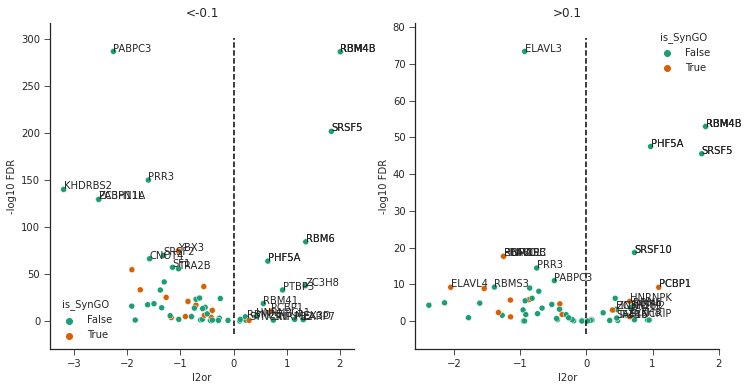

In [6]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_individual.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'l2or', y = '-log10 FDR', ax = ax, hue = 'is_SynGO')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'odds ratio', ascending = False).iloc[:15]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:15]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['l2or'], row['-log10 FDR'], row['experiment'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [7]:
stat_individual.loc[stat_individual['experiment'].str.contains('SNRNP')]

,experiment,category,p-value,odds ratio,sig,FDR,l2or,-log10 FDR,RBP,is_SynGO
32,SNRNP70_GTTCAAGGTG,<-0.1,1.0,0.0,False,1.0,-inf,-0.0,SNRNP70,False
33,SNRNP70_GTTCAAGGTG,>0.1,1.0,0.0,False,1.0,-inf,-0.0,SNRNP70,False


In [9]:
snrnp_score = data.merge(df.loc[df['Motif Name'].str.contains('SNRNP70')],
                         left_index = True, right_on = 'FASTA ID')

In [10]:
snrnp_score['subseq'].str.contains('GTTCAAGGTG')

1508124    True
1508123    True
1508122    True
1508121    True
1508120    True
           ... 
1507913    True
1507912    True
1507911    True
1507910    True
1507909    True
Name: subseq, Length: 216, dtype: bool

In [ ]:
# stat = []
# for exp in df['Motif Name'].unique():
#     for annotation in ['UTR5', 'CDS', 'UTR3']:
#         for cat in ['<-0.1', '>0.1']:
#             has_motif = set(df.loc[df['Motif Name']==exp, 'FASTA ID'])
            
#             positive = set(data.loc[(data['annotation']==annotation)&
#                                         (data['difference_bin']==cat),
#                                         ].index)
#             negative = set(data.loc[(data['annotation']==annotation)&
#                                         (data['difference_bin']=='middle')].index)
                                        
#             contingency = pd.DataFrame(np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
#                                   [len(has_motif.intersection(negative)), len(negative-has_motif)]]
#                                  ),
#                                        index = [True, False],
#                                        columns = [True, False]
#                                       )
        
#             pv, or_ = testing(contingency)
#             stat.append([annotation, exp, cat, pv, or_])
#             print(exp)
# stat = pd.DataFrame(stat,columns = ['annotation', 'experiment', 'category', 'p-value', 'odds ratio']) 

In [ ]:
# from statsmodels.stats.multitest import fdrcorrection
# fdr_thres = 0.2
# stat['sig'],stat['FDR'] = fdrcorrection(stat['p-value'], alpha = fdr_thres)

In [ ]:
# stat.loc[stat['sig']]

In [ ]:
# stat['l2or'] = np.log2(stat['odds ratio'])
# stat['-log10 FDR']= -np.log10(stat['FDR'])

In [ ]:
# stat.to_csv(outdir / 'motif_enrichment_human.csv')

In [ ]:
# f, axes = plt.subplots(2,3, figsize = (15,10))
# for ax, (name, group) in zip(axes.flatten(),stat.groupby(by = ['category', 'annotation'])):
#     group.plot.scatter(x = 'l2or', y = '-log10 FDR', ax = ax)
#     ax.set_title(name)
#     sig1 = group.loc[(group['sig'])].sort_values(by = 'odds ratio', ascending = False).iloc[:5]
#     sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
#     sig = pd.concat([sig1, sig2], axis = 0)
#     for index, row in sig.iterrows():
#         ax.text(row['l2or'], row['-log10 FDR'], row['experiment'].split('_')[0])
#     ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
# sns.despine()

In [ ]:
# contigency = np.array([[len(has_motif.intersection(positive)), len(positive-has_motif)],
#                                   [len(has_motif.intersection(negative)), len(negative-has_motif)]]
#                                  )

In [ ]:
# contigency

In [ ]:
# pd.pivot_table(df, index = 'FASTA ID', columns = 'Motif Name', values = 'MotifScore')